In [196]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from scipy.stats import beta
epochs = 5000

In [197]:
class Batch:
    quality = 0.5
    alpha = 1
    beta = 1

    def __init__(self, quality):
        self.quality = quality

    def sample_distribution(self):
        return np.random.beta(self.alpha, self.beta)

    def get_element(self):
        good = np.random.rand() < self.quality
        self.alpha = self.alpha + int(good)
        self.beta = self.beta + 1 - int(good)
        return good

In [198]:
class Factory:
    batches = []
    systems = 0
    good = 0

    def set_batches(self, qualities):
        self.batches = [Batch(quality) for quality in qualities]
        self.systems = 0
        self.good = 0

    def get_element(self):
        samples = [batch.sample_distribution() for batch in self.batches]
        choice = np.argmax(samples)
        result = self.batches[choice].get_element()
        self.systems = self.systems + 1
        self.good = self.good + int(result)

In [199]:
batches = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

factorium = Factory()
factorium.set_batches(batches)
for _ in range(epochs):
    factorium.get_element()
print(f'Score is {factorium.good / factorium.systems}')

Score is 0.9498


In [200]:
for idx in range(len(factorium.batches)):
    print(factorium.batches[idx].alpha, factorium.batches[idx].beta)

2 4
1 3
33 8
13 6
52 9
4654 227


<h1><center><font size="10">First strategy</font></center></h1>

In [201]:
class Factory_if_bad_then_next:
    def __init__(self):
        self.batches = []
        self.systems = 0
        self.good = 0
        self.index = 0

    def set_batches(self, qualities):
        self.batches = [Batch(quality) for quality in qualities]
        self.systems = 0
        self.good = 0

    def get_element(self):
        result = self.batches[self.index].get_element()
        if not result:
            self.index += 1
            if self.index == len(self.batches):
                self.index = 0
        self.systems = self.systems + 1
        self.good = self.good + int(result)

In [202]:
factorium_ibtn = Factory_if_bad_then_next()
factorium_ibtn.set_batches(batches)
for _ in range(epochs):
    factorium_ibtn.get_element()
print(f'Score is {factorium_ibtn.good / factorium_ibtn.systems}')

Score is 0.8562


In [203]:
for idx in range(len(factorium.batches)):
    print(factorium.batches[idx].alpha, factorium.batches[idx].beta)

2 4
1 3
33 8
13 6
52 9
4654 227


<h1><center><font size="10">Second strategy</font></center></h1>

In [204]:
class Factory_ranking_simple:
    def __init__(self, target_sample_count: int):
        self.batches = []
        self.systems = 0
        self.good = 0
        self.batch_ranking = dict()
        self.index = 0
        self.sample_count = 0
        self.target_sample_count = target_sample_count

    def set_batches(self, qualities):
        self.batches = [Batch(quality) for quality in qualities]
        self.systems = 0
        self.good = 0

    def rank_batches(self):
        for batch in range(len(self.batches)):
            self.batch_ranking[batch] = [0, 0, 0]

    def get_element(self):
        while self.sample_count < self.target_sample_count:
            if self.systems < (len(self.batches) * 2):
                result = self.batches[self.index].get_element()
                good_value = self.batch_ranking[self.index][0]
                sum_value = self.batch_ranking[self.index][1]

                self.batch_ranking[self.index] = [good_value + int(result),
                                                  sum_value + 1,
                                                  (good_value + int(result)) / (sum_value + 1)]

                self.systems = self.systems + 1
                self.good = self.good + int(result)

                self.index += 1
                if self.index == len(self.batches):
                    self.index = 0

                self.sample_count += 1

            else:
                sorted_best_ratios = sorted(self.batch_ranking.items(), key=lambda x:x[1][2])
                for n_elements_to_pick, batch_index in enumerate(sorted_best_ratios):
                    for _ in range(0, n_elements_to_pick + 1):
                        result = self.batches[batch_index[0]].get_element()
                        good_value = self.batch_ranking[batch_index[0]][0]
                        sum_value = self.batch_ranking[batch_index[0]][1]

                        self.batch_ranking[batch_index[0]] = [good_value + int(result),
                                                              sum_value + 1,
                                                              (good_value + int(result)) / (sum_value + 1)]
                        self.systems = self.systems + 1
                        self.good = self.good + int(result)
                        self.sample_count += 1

In [205]:
factorium_ranking_simple = Factory_ranking_simple(target_sample_count=epochs)
factorium_ranking_simple.set_batches(batches)
factorium_ranking_simple.rank_batches()
factorium_ranking_simple.get_element()
print(f'Score is {factorium_ranking_simple.good / factorium_ranking_simple.systems}')

Score is 0.8133732534930139


In [206]:
for idx in range(len(factorium.batches)):
    print(factorium_ranking_simple.batches[idx].alpha, factorium_ranking_simple.batches[idx].beta)

117 125
294 191
510 217
736 211
1083 121
1341 76


<h1><center><font size="10">Third strategy</font></center></h1>

In [207]:
class Factory_ranking_hard:
    def __init__(self, target_sample_count: int):
        self.batches = []
        self.systems = 0
        self.good = 0
        self.batch_ranking = dict()
        self.index = 0
        self.sample_count = 0
        self.target_sample_count = target_sample_count
        self.ratios = []

    def set_batches(self, qualities):
        self.batches = [Batch(quality) for quality in qualities]
        self.systems = 0
        self.good = 0

    def rank_batches(self):
        for batch in range(len(self.batches)):
            self.batch_ranking[batch] = [0, 0, 0]

    def get_element(self):
        while self.sample_count < self.target_sample_count:
            if self.systems < (len(self.batches) * 2):
                result = self.batches[self.index].get_element()
                good_value = self.batch_ranking[self.index][0]
                sum_value = self.batch_ranking[self.index][1]

                self.batch_ranking[self.index] = [good_value + int(result),
                                                  sum_value + 1,
                                                  (good_value + int(result)) / (sum_value + 1)]

                self.systems = self.systems + 1
                self.good = self.good + int(result)

                self.index += 1
                if self.index == len(self.batches):
                    self.index = 0

                self.sample_count += 1

            else:
                sorted_best_ratios = sorted(self.batch_ranking.items(), key=lambda x:x[1][2])
                self.ratios.append(1)
                for batch in range(len(sorted_best_ratios) - 1):
                    try:
                        self.ratios.append(int(sorted_best_ratios[batch + 1][1][2] / sorted_best_ratios[batch][1][2]))
                    except ZeroDivisionError:
                        self.ratios.append(1)

                value = 1
                for position, batch_index in enumerate(sorted_best_ratios):
                    value *= self.ratios[position]
                    for _ in range(0, value):
                        result = self.batches[batch_index[0]].get_element()
                        good_value = self.batch_ranking[batch_index[0]][0]
                        sum_value = self.batch_ranking[batch_index[0]][1]

                        self.batch_ranking[batch_index[0]] = [good_value + int(result),
                                                              sum_value + 1,
                                                              (good_value + int(result)) / (sum_value + 1)]
                        self.systems = self.systems + 1
                        self.good = self.good + int(result)
                        self.sample_count += 1

In [208]:
factorium_ranking_hard = Factory_ranking_hard(target_sample_count=epochs)
factorium_ranking_hard.set_batches(batches)
factorium_ranking_hard.rank_batches()
factorium_ranking_hard.get_element()
print(f'Score is {factorium_ranking_hard.good / factorium_ranking_hard.systems}')

Score is 0.7438049560351718


In [209]:
for idx in range(len(factorium_ranking_hard.batches)):
    print(factorium_ranking_hard.batches[idx].alpha, factorium_ranking_hard.batches[idx].beta)

412 424
511 325
593 243
670 166
748 88
794 42


<h1><center><font size="10">Own strategy</font></center></h1>

In [210]:
class Factory_roulette:
    def __init__(self, target_sample_count: int):
        self.batches = []
        self.systems = 0
        self.good = 0
        self.batch_ranking = dict()
        self.index = 0
        self.sample_count = 0
        self.target_sample_count = target_sample_count
        self.ratios = []

    def set_batches(self, qualities):
        self.batches = [Batch(quality) for quality in qualities]
        self.systems = 0
        self.good = 0

    def rank_batches(self):
        for batch in range(len(self.batches)):
            self.batch_ranking[batch] = [0, 0, 0]

    def get_element(self):
        while self.sample_count < self.target_sample_count:
            if self.systems < int(self.target_sample_count * 0.01):
                result = self.batches[self.index].get_element()
                good_value = self.batch_ranking[self.index][0]
                sum_value = self.batch_ranking[self.index][1]

                self.batch_ranking[self.index] = [good_value + int(result),
                                                  sum_value + 1,
                                                  (good_value + int(result)) / (sum_value + 1)]

                self.systems = self.systems + 1
                self.good = self.good + int(result)

                self.index += 1
                if self.index == len(self.batches):
                    self.index = 0

                self.sample_count += 1

            else:
                sorted_best_ratios = sorted(self.batch_ranking.items(), key=lambda x:x[1][2])
                keys, values = list(), list()
                for index in range(len(sorted_best_ratios)):
                    keys.append(sorted_best_ratios[index][0])
                    values.append(sorted_best_ratios[index][1])

                choice = rd.choices(keys, weights=[value[2] * (index + 1) for index, value in enumerate(values)])[0]
                result = self.batches[choice].get_element()
                good_value = self.batch_ranking[choice][0]
                sum_value = self.batch_ranking[choice][1]

                self.batch_ranking[choice] = [good_value + int(result),
                                              sum_value + 1,
                                              (good_value + int(result)) / (sum_value + 1)]

                self.systems = self.systems + 1
                self.good = self.good + int(result)
                self.sample_count += 1

In [211]:
factorium_roulette = Factory_roulette(target_sample_count=epochs)
factorium_roulette.set_batches(batches)
factorium_roulette.rank_batches()
factorium_roulette.get_element()
print(f'Score is {factorium_roulette.good / factorium_roulette.systems}')

Score is 0.8422


In [212]:
for idx in range(len(factorium_roulette.batches)):
    print(factorium_roulette.batches[idx].alpha, factorium_roulette.batches[idx].beta)

112 94
186 118
410 180
769 180
1151 136
1589 87


In [213]:
plt.rcParams["figure.figsize"] = (10,5)

In [214]:
def plot_beta(factory, plot_name: str):
    fig, ax = plt.subplots()
    alphas = []
    betas = []
    for batch in factory.batches:
        alphas.append(batch.alpha)
        betas.append(batch.beta)

    for batch in range(len(alphas)):
        x = np.linspace(beta.ppf(0.000001, alphas[batch], betas[batch]),
                        beta.ppf(0.999999, alphas[batch], betas[batch]), 100)

        ax.plot(x, beta.pdf(x, alphas[batch], betas[batch]), label=str(f'#{batch}, quality = {factory.batches[batch].quality}'))

    plt.title(plot_name)
    plt.xlabel('Probability distribution')
    plt.ylabel('Probability distribution')
    plt.legend()

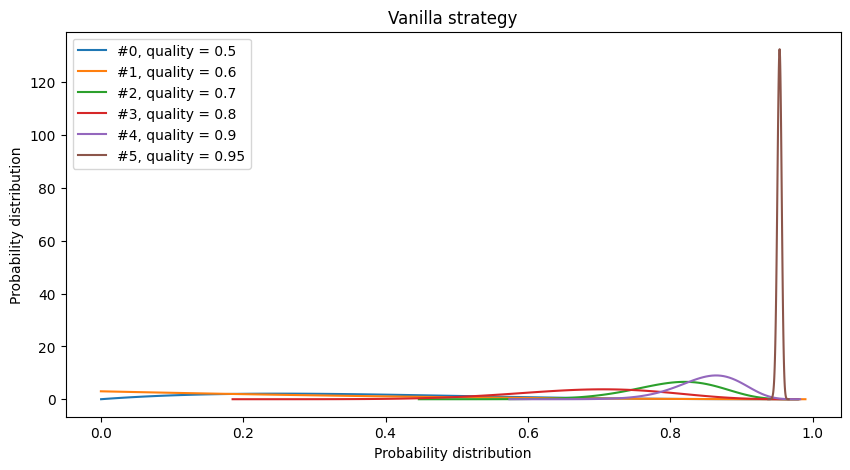

In [215]:
plot_beta(factorium, 'Vanilla strategy')

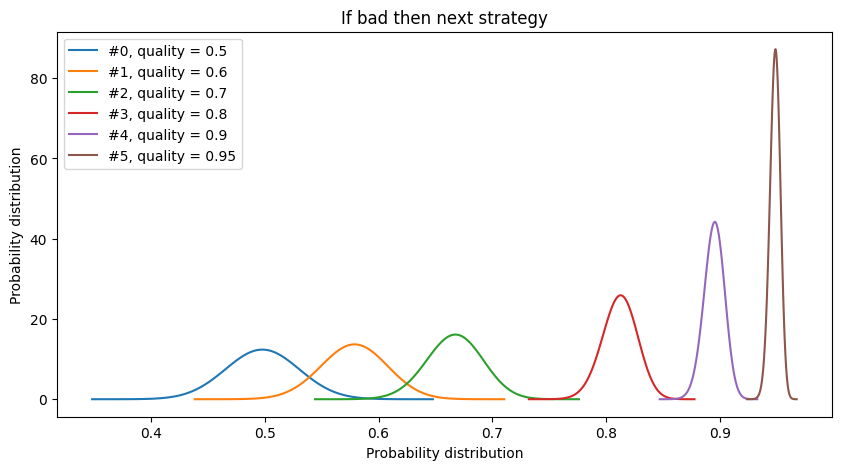

In [216]:
plot_beta(factorium_ibtn, 'If bad then next strategy')

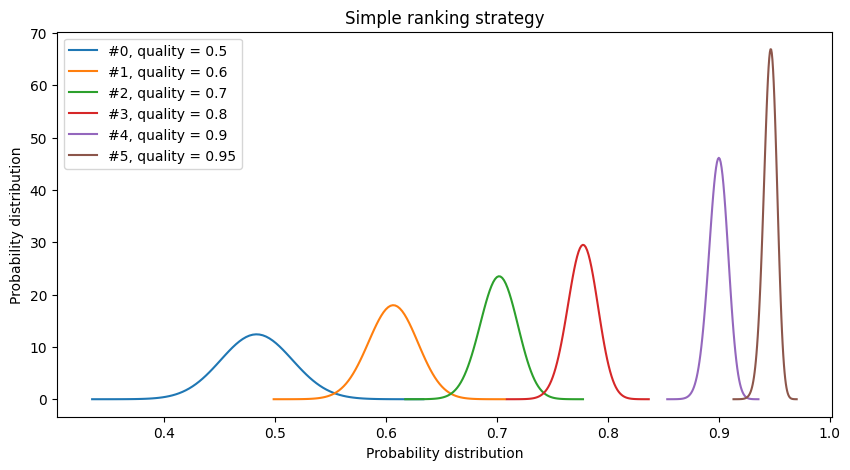

In [217]:
plot_beta(factorium_ranking_simple, 'Simple ranking strategy')

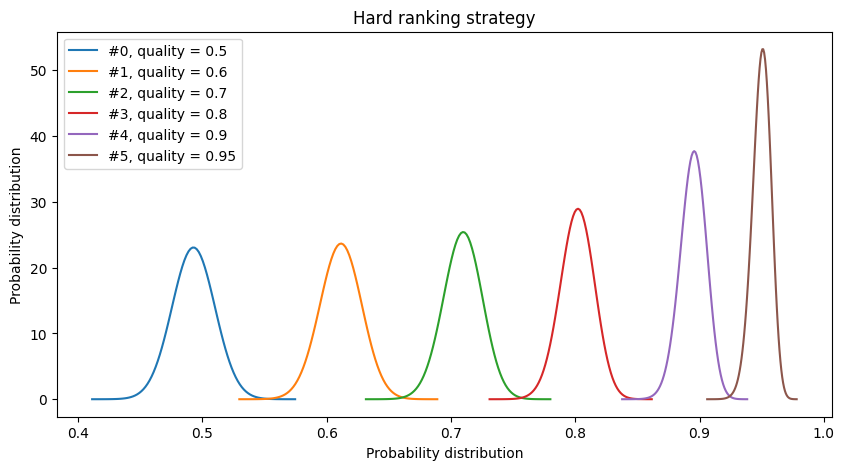

In [218]:
plot_beta(factorium_ranking_hard, 'Hard ranking strategy')

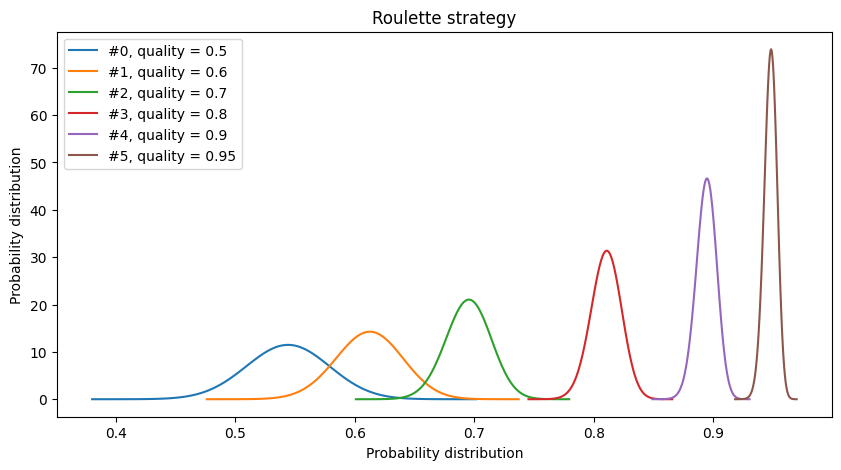

In [219]:
plot_beta(factorium_roulette, 'Roulette strategy')

<h1><center><font size="10">Changing quality over time</font></center></h1>

In [220]:
class ForgettableBatch:
    def __init__(self, quality):
        self.quality = quality
        self.alpha = 1
        self.beta = 1

    def sample_distribution(self):
        return np.random.beta(self.alpha, self.beta)

    def get_element(self):
        good = np.random.rand() < self.quality
        self.alpha = self.alpha + int(good)
        self.beta = self.beta + 1 - int(good)
        return good

    def forget(self):
        self.alpha *= 0.99
        self.beta *= 0.99

        if self.alpha < 1: self.alpha = 1
        if self.beta < 1: self.beta = 1

In [221]:
class ForgettableFactory:
    batches = []
    systems = 0
    good = 0

    def set_batches(self, qualities):
        self.batches = [ForgettableBatch(quality) for quality in qualities]
        self.systems = 0
        self.good = 0

    def get_element(self):
        samples = [batch.sample_distribution() for batch in self.batches]
        choice = np.argmax(samples)
        result = self.batches[choice].get_element()
        [batch.forget() for batch in self.batches]
        self.systems = self.systems + 1
        self.good = self.good + int(result)

Score is 0.8464


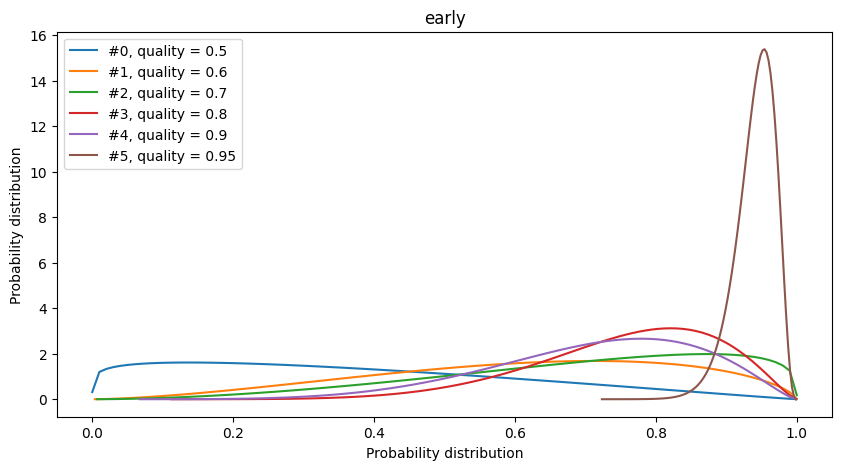

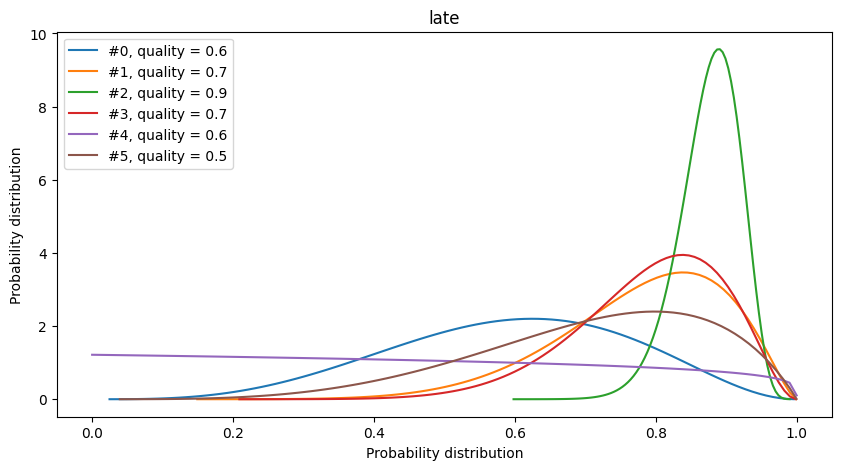

In [222]:
batches = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
improved_batches = [0.6, 0.7, 0.9, 0.7, 0.6, 0.5]

factorium = ForgettableFactory()
factorium.set_batches(batches)

for idx in range(epochs):

    if idx == epochs / 2:
        plot_beta(factorium, 'early')
        for batch_idx, batch in enumerate(factorium.batches):
            batch.quality = improved_batches[batch_idx]

    factorium.get_element()

plot_beta(factorium, 'late')
print(f'Score is {factorium.good / factorium.systems}')

In [223]:
for idx in range(len(factorium.batches)):
    print(factorium.batches[idx].alpha, factorium.batches[idx].beta)

4.538609552707654 3.125708674172631
8.824750101020603 2.5045596879634395
51.03153572955203 7.225543614239083
11.382433849328686 3.0090294838301075
1 1.2156958100704798
4.780336527575035 1.9559760386081544
